Hybrid of Distil Bert/Machine Learning using Stacking with Meta Learning in detecting SQLi attacks in Web Application Firewall Pipeline

In [ ]:
import warnings # Import the warnings module
warnings.filterwarnings('ignore') # Ignore all warnings

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:
from google.colab import files
upload = files.upload()

Saving SQL_Injection_Dataset.csv to SQL_Injection_Dataset.csv


In [ ]:
# Importing  Libraries

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import xgboost as xgb
import torch.nn as nn
import torch.optim as optim
import time
import joblib
import torch
import torch.nn.functional as F
import optuna
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve





In [ ]:
# Setting a roandom seed to ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Loading and printing SQL Injection(SQLi)  dataset
df = pd.read_csv('SQL_Injection_Dataset.csv')
df

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1
...,...,...
30914,DELETE FROM door WHERE grow = 'small',0
30915,DELETE FROM tomorrow,0
30916,SELECT wide ( s ) FROM west,0
30917,SELECT * FROM ( SELECT slide FROM breath ),0


In [ ]:
# Printing SQLi Dataset dimension
df.shape

(30919, 2)

In [ ]:
# data types of the  features
print(df.dtypes)


Query    object
Label     int64
dtype: object


In [ ]:
# Displaying information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


In [ ]:
# descriptive statistics for all attributes
df.describe(include='all')

,Query,Label
count,30919,30919.000000
unique,30905,NaN
top,#NAME?,NaN
freq,8,NaN
mean,NaN,0.368123
std,NaN,0.482303
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [ ]:
# Checking for missing values
Missing_values = df.isnull().sum()
print("Missing Values:")
Missing_values


Missing Values:


,0
Query,0
Label,0


In [ ]:
# Cleaning text and creating new feafure  length_column
df['Query'] = df['Query'].apply(lambda x: x.lower().strip())
df['Query_Length'] = df['Query'].apply(lambda x: len(x.split()))

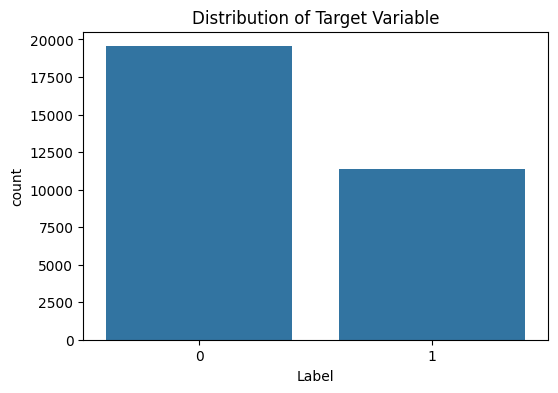

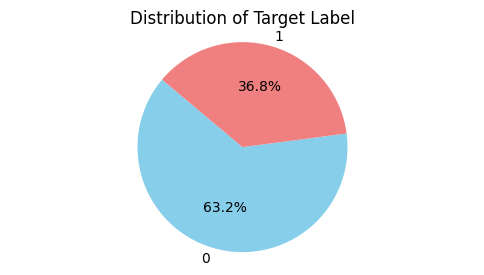

In [ ]:
# Ploting distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Target Variable')
plt.show()

# Counting the occurrences of each label
label_counts = df['Label'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(6, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Label')
plt.axis('equal')
plt.show()


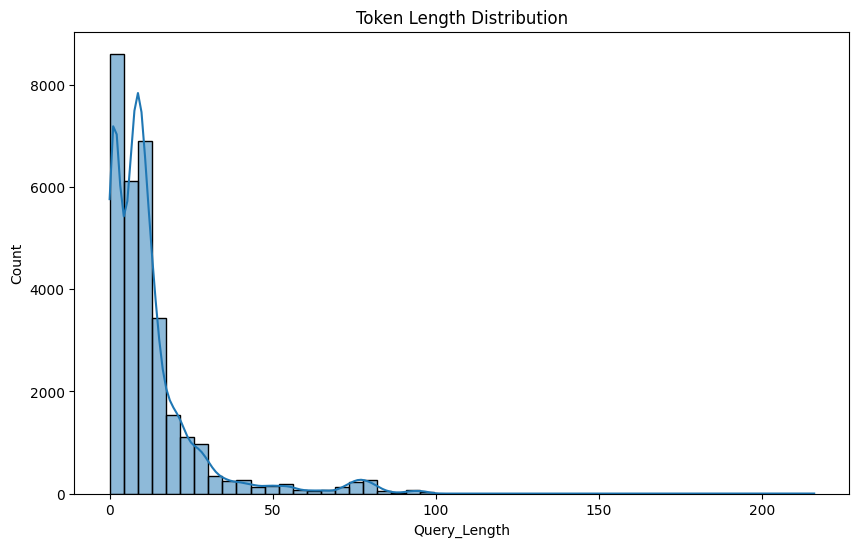

In [ ]:
# Ploting token length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Query_Length'], bins=50, kde=True)
plt.title('Token Length Distribution')
plt.show()

In [ ]:
# Determining the 99th percentile for query_length
query_length_threshold = df['Query_Length'].quantile(0.99)
print(f"99th percentile of query length: {query_length_threshold}")

99th percentile of query length: 79.0


In [ ]:
# Retaining all data points, including outliers
df_no_outliers = df  # No outlier removal


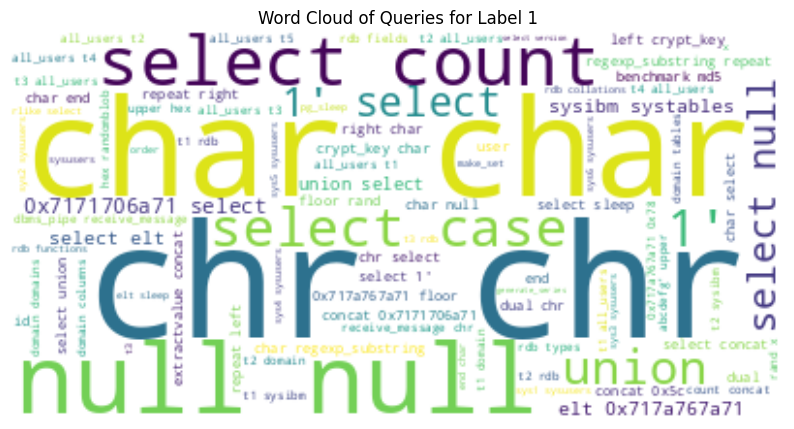

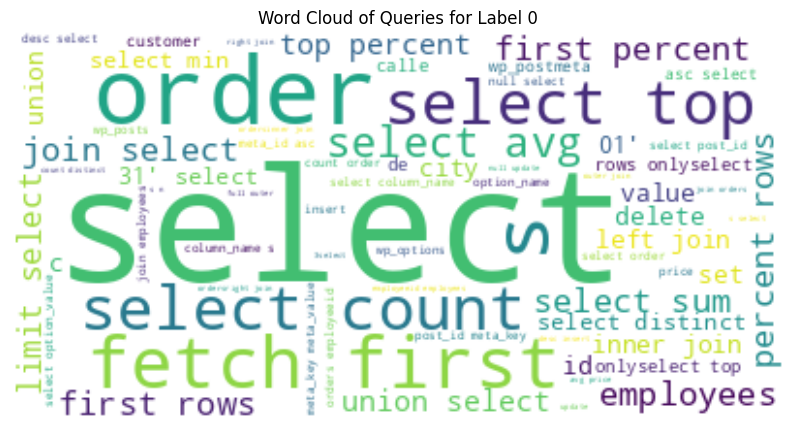

In [ ]:
# Generating word clouds for each label
for label in df['Label'].unique():
    text = " ".join(query for query in df[df['Label'] == label]['Query'])
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud of Queries for Label {label}")
    plt.show()

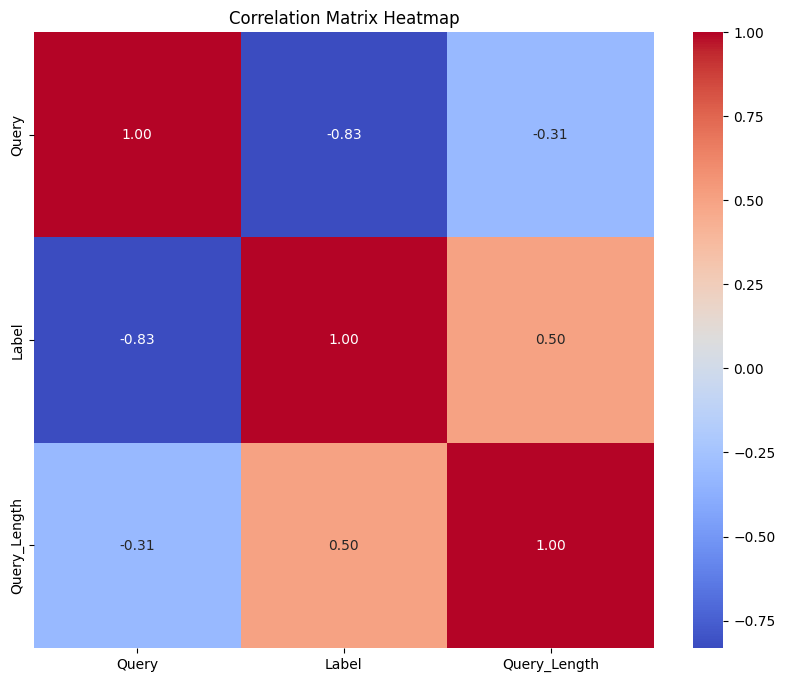

In [ ]:
# Encoding categorical features for correlation analysis
df_encoded = df.copy()
df_encoded['Query'] = df_encoded['Query'].factorize()[0]

# Computing the correlation matrix
corr_matrix = df_encoded.corr()

# Generating a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


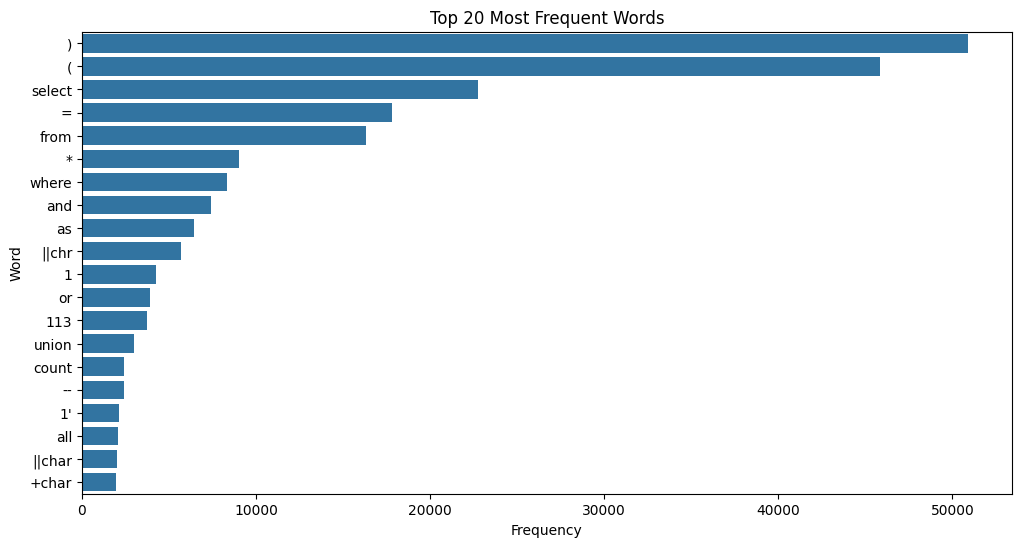

In [ ]:
# Spliting each Query into words and create a list of all words
words = [word for query in df['Query'] for word in query.split()]

# Counting the frequency of each word
word_counts = Counter(words)

# Creating a dataframe for the word frequencies
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Ploting  word frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

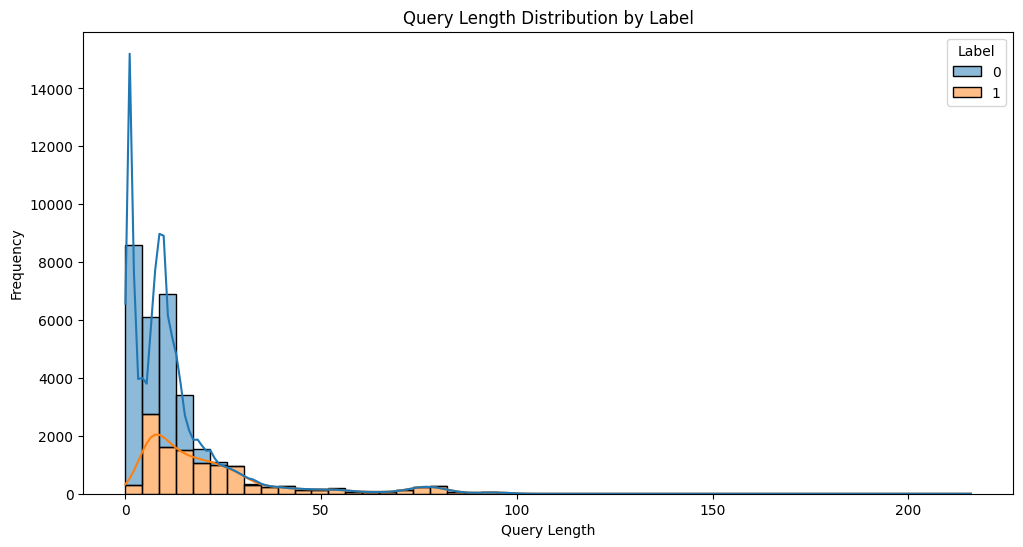

In [ ]:
# Visualising Query_Length Distribution by Label
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Query_Length', hue='Label', multiple='stack', bins=50, kde=True)
plt.title('Query Length Distribution by Label')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()

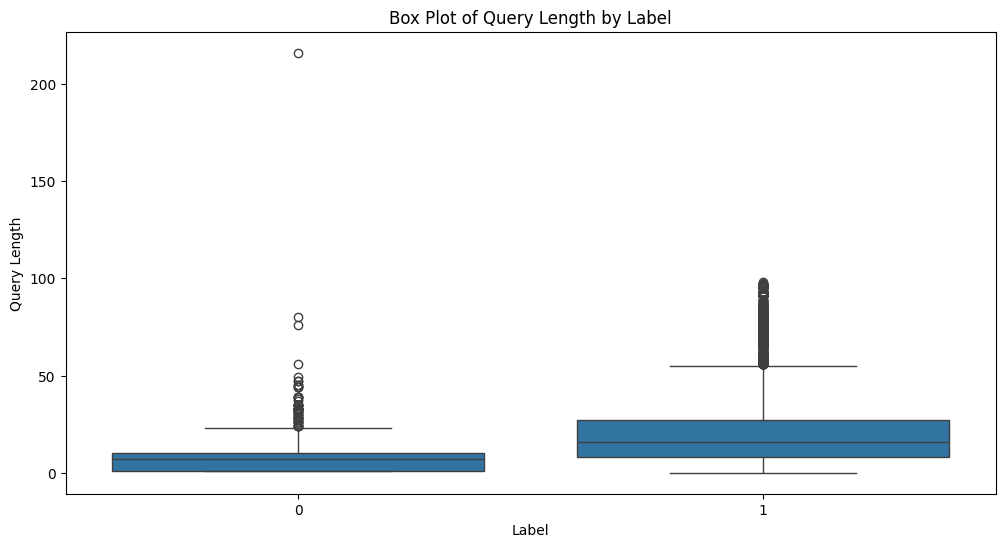

In [ ]:
# Box plots for query_length by label
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Query_Length', data=df)
plt.title('Box Plot of Query Length by Label')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.show()

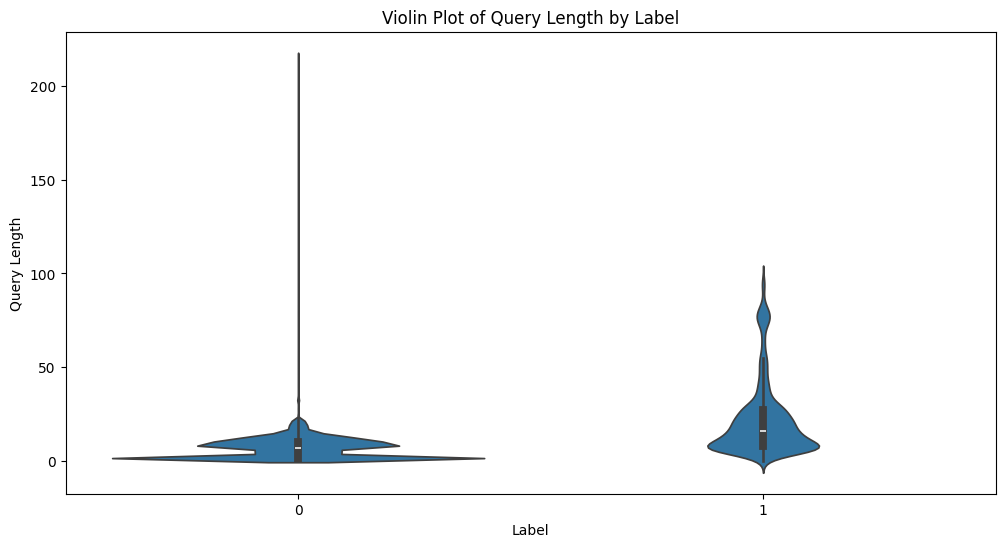

In [ ]:
# Violin plots for query_length by label
plt.figure(figsize=(12, 6))
sns.violinplot(x='Label', y='Query_Length', data=df)
plt.title('Violin Plot of Query Length by Label')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.show()

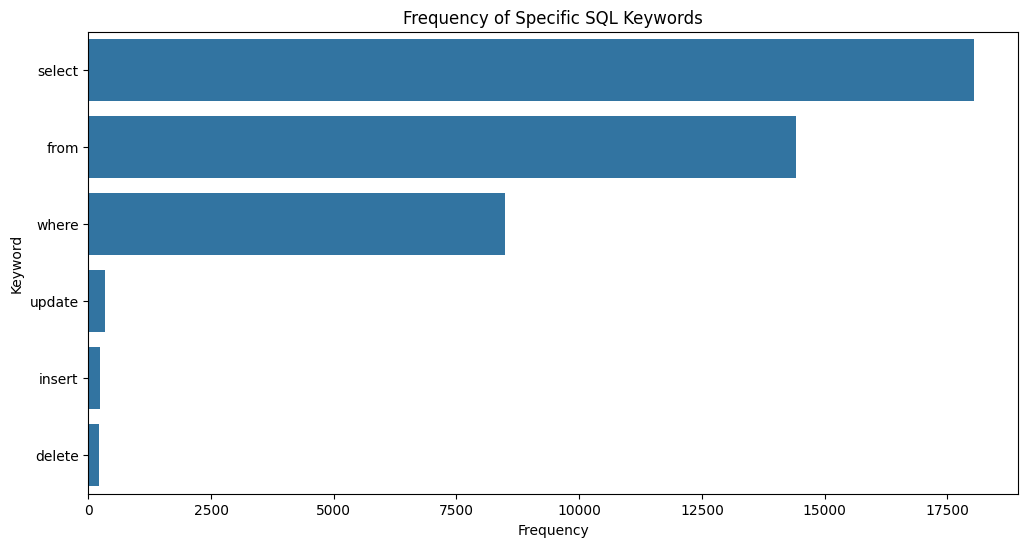

In [ ]:
# Frequency of specific SQL keywords
keywords = ['select', 'from', 'where', 'insert', 'update', 'delete']
keyword_counts = {keyword: df['Query'].str.contains(keyword, case=False).sum() for keyword in keywords}

# Creating a dataframe for keyword frequencies
keyword_freq_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Ploting the keyword frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Keyword', data=keyword_freq_df)
plt.title('Frequency of Specific SQL Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

In [ ]:
# Droping the Query_Length column as it's no longer needed
df_no_outliers = df_no_outliers.drop(columns='Query_Length')

In [ ]:
# Displaying basic information about SQLi dataset
print(df_no_outliers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Query         30919 non-null  object
 1   Label         30919 non-null  int64 
 2   Query_Length  30919 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 724.8+ KB
None


In [ ]:
# Displaying summary statistics
print(df_no_outliers.describe())


              Label  Query_Length
count  30919.000000  30919.000000
mean       0.368123     12.414535
std        0.482303     14.928521
min        0.000000      0.000000
25%        0.000000      4.000000
50%        0.000000      9.000000
75%        1.000000     14.000000
max        1.000000    216.000000


In [ ]:
# Checking for missing values
missing_values = df_no_outliers.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Query           0
Label           0
Query_Length    0
dtype: int64


In [ ]:
# Analysing class distribution
class_distribution = df_no_outliers['Label'].value_counts(normalize=True)
print("Class distribution:\n", class_distribution)


Class distribution:
 Label
0    0.631877
1    0.368123
Name: proportion, dtype: float64


In [ ]:
# Class distribution
class_distribution = df['Label'].value_counts(normalize=True)
average_query_length = df['Query_Length'].mean()

# Summary and insights from the Exploratory Data analysis
print("Summary and Insights:")
print(f"1. The dataset contains {df.shape[0]} samples and {df.shape[1]} features after filtering for binary classification.")
print(f"2. The target variable is imbalanced with the following distribution:\n{class_distribution}")
print(f"3. The average query length is {average_query_length:.2f} words.")
print(f"4. No missing values were found in the 'Query' and 'Label' columns after preprocessing.")
print(f"5. The distribution of 'Query_Length' shows that there is a variation in the length of queries, which could be indicative of different types of queries.")
print("6. The word cloud visualization indicates that common SQL keywords such as 'select', 'from', and 'where' are frequently used in the queries.")
print("7. Correlation analysis did not reveal strong linear relationships between features, which is expected given the nature of text data.")


Summary and Insights:
1. The dataset contains 30919 samples and 3 features after filtering for binary classification.
2. The target variable is imbalanced with the following distribution:
Label
0    0.631877
1    0.368123
Name: proportion, dtype: float64
3. The average query length is 12.41 words.
4. No missing values were found in the 'Query' and 'Label' columns after preprocessing.
5. The distribution of 'Query_Length' shows that there is a variation in the length of queries, which could be indicative of different types of queries.
6. The word cloud visualization indicates that common SQL keywords such as 'select', 'from', and 'where' are frequently used in the queries.
7. Correlation analysis did not reveal strong linear relationships between features, which is expected given the nature of text data.


Data Preprocessing and Feature Extraction with DistilBERT

In [ ]:
# Encoding labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


In [ ]:
# Spliting dataframe into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# Initialising tokenizer to extract embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Tokenising SQL queries
def tokenize_queries(queries):
    return tokenizer(queries.tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

train_encodings = tokenize_queries(train_df['Query'])
test_encodings = tokenize_queries(test_df['Query'])

In [ ]:
# Computing class weights to balance the class distribution
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['Label']), y=train_df['Label'])
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Function to extract BERT embeddings
def get_bert_embeddings(encodings, model, device, batch_size=16):
    model.eval()
    embeddings = []
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i+batch_size].to(device)
        batch_attention_mask = attention_mask[i:i+batch_size].to(device)
        with torch.no_grad():
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu())
    return torch.cat(embeddings, dim=0)


In [ ]:
# Loading BERT model and extracting embeddings
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
train_embeddings = get_bert_embeddings(train_encodings, bert_model, device)
test_embeddings = get_bert_embeddings(test_encodings, bert_model, device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training  and Evaluating Machine Learning and Ensmble  Classifiers with DistilBERT embeddings

In [ ]:
# Converting integer labels to strings for printing classification_report
target_names = [str(i) for i in label_encoder.classes_]

# Defining classifiers with hyperparameter tuning
classifiers = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=class_weights[1])
}

# Define hyperparameter grids for GridSearchCV
param_grids = {
    "Random Forest": {'n_estimators': [50, 100, 200]},
    "Decision Tree": {'max_depth': [None, 10, 20]},
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "Gradient Boosting": {'n_estimators': [50, 100, 200]},
    "XGBoost": {'n_estimators': [50, 100, 200]}
}

# Training and evaluating classifiers
results = {}
train_times = {}
execution_times = {}
trained_classifiers = {}
for name, clf in classifiers.items():
    print(f"Training {name} with cross-validation...")

    # Measuring training time
    start_time = time.time()
    if name in param_grids:
        clf = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    else:
        clf.fit(train_embeddings, train_df['Label'])
    clf.fit(train_embeddings, train_df['Label'])
    end_time = time.time()
    train_times[name] = end_time - start_time

    # Measuring execution time
    start_exec_time = time.time()
    preds = clf.predict(test_embeddings)
    end_exec_time = time.time()
    execution_times[name] = end_exec_time - start_exec_time

    accuracy = accuracy_score(test_df['Label'], preds)
    report = classification_report(test_df['Label'], preds, target_names=target_names, output_dict=True)
    conf_matrix = confusion_matrix(test_df['Label'], preds)

    # Storing results
    results[name] = {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": conf_matrix,
        "train_time": train_times[name],
        "execution_time": execution_times[name]
    }

    trained_classifiers[name] = clf
    print(f"Finished training {name}.")
    print(f"Training time: {train_times[name]:.2f} seconds")
    print(f"Execution time: {execution_times[name]:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(test_df['Label'], preds, target_names=target_names)}")
    print('--------------------------------------------------')


Training Random Forest with cross-validation...
Finished training Random Forest.
Training time: 501.95 seconds
Execution time: 0.13 seconds
Accuracy: 0.9945
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3893
           1       1.00      0.99      0.99      2291

    accuracy                           0.99      6184
   macro avg       1.00      0.99      0.99      6184
weighted avg       0.99      0.99      0.99      6184

--------------------------------------------------
Training Decision Tree with cross-validation...
Finished training Decision Tree.
Training time: 198.54 seconds
Execution time: 0.00 seconds
Accuracy: 0.9799
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3893
           1       0.98      0.97      0.97      2291

    accuracy                           0.98      6184
   macro avg       0.98      0.98      0.98 

                 Model  Accuracy  Precision    Recall  F1-Score  \
0        Random Forest  0.994502   0.994537  0.994502  0.994494   
1        Decision Tree  0.979948   0.979933  0.979948  0.979934   
2          Naive Bayes  0.897639   0.899180  0.897639  0.898109   
3  Logistic Regression  0.997574   0.997576  0.997574  0.997575   
4                  SVM  0.998221   0.998221  0.998221  0.998221   
5    Gradient Boosting  0.995634   0.995635  0.995634  0.995632   
6              XGBoost  0.997413   0.997413  0.997413  0.997412   

   Training Time (s)  Execution Time (s)  
0         501.950003            0.129869  
1         198.535384            0.003915  
2           0.273896            0.068014  
3          28.319811            0.016831  
4         471.574498            1.896439  
5        4204.557177            0.038950  
6          69.018749            0.042038  


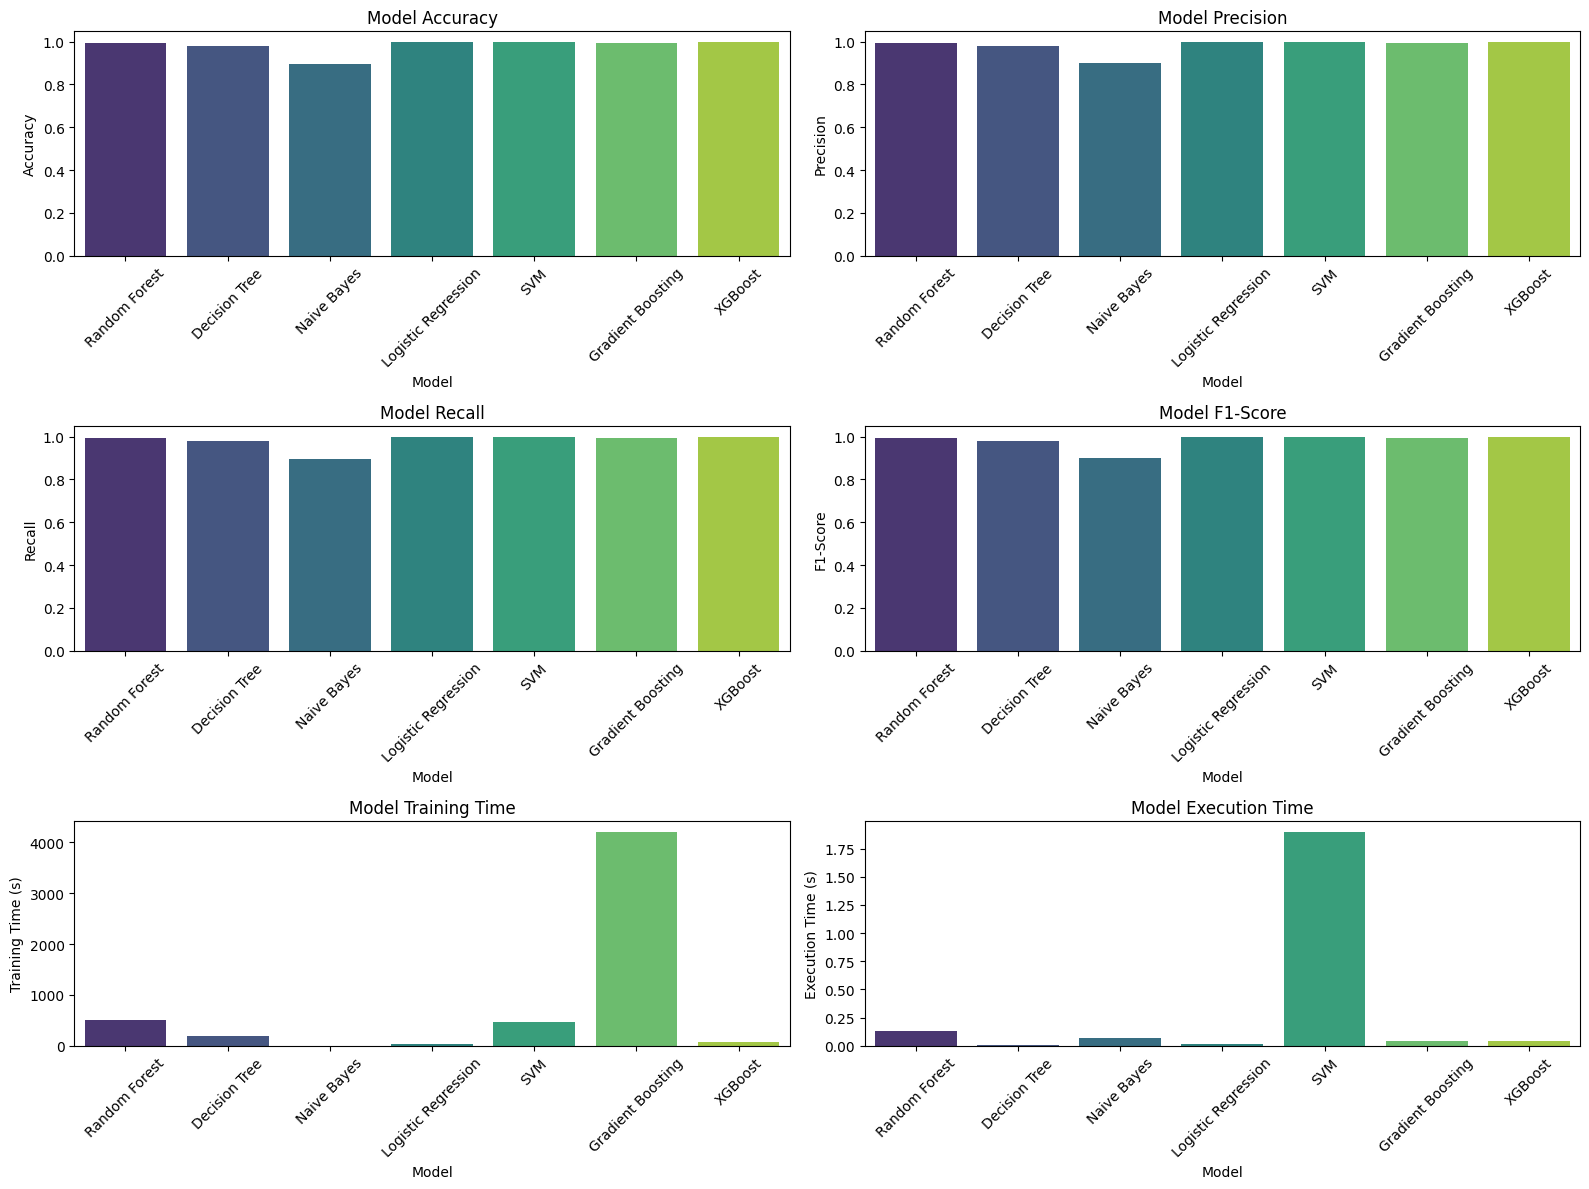

In [ ]:
# Display the results summaries of the ML and Ensemble models.
performance_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Training Time (s)': [],
    'Execution Time (s)': []
}

for name, result in results.items():
    performance_metrics['Model'].append(name)
    performance_metrics['Accuracy'].append(result['accuracy'])
    performance_metrics['Precision'].append(result['report']['weighted avg']['precision'])
    performance_metrics['Recall'].append(result['report']['weighted avg']['recall'])
    performance_metrics['F1-Score'].append(result['report']['weighted avg']['f1-score'])
    performance_metrics['Training Time (s)'].append(train_times[name])
    performance_metrics['Execution Time (s)'].append(execution_times[name])

performance_df = pd.DataFrame(performance_metrics)

# Displaying the summary table
print(performance_df)

# Ploting bar graphs for accuracy, precision, recall, F1-score, training time, and execution time
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Accuracy')

plt.subplot(3, 2, 2)
sns.barplot(x='Model', y='Precision', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Precision')

plt.subplot(3, 2, 3)
sns.barplot(x='Model', y='Recall', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Recall')

plt.subplot(3, 2, 4)
sns.barplot(x='Model', y='F1-Score', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model F1-Score')

plt.subplot(3, 2, 5)
sns.barplot(x='Model', y='Training Time (s)', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Training Time')

plt.subplot(3, 2, 6)
sns.barplot(x='Model', y='Execution Time (s)', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Execution Time')

plt.tight_layout()
plt.show()

Creating a DistilBERT-Stacked Ensemble(Meta-Learner) with best performing models and training it with adversarial examples using Fast Sign Gradient Method.(FSGM)

In [ ]:
# Creating meta-features using the Top 3 performing models
selected_models = ["Logistic Regression", "XGBoost", "SVM"]
train_meta_features = np.column_stack([
    cross_val_predict(trained_classifiers[name], train_embeddings, train_df['Label'], cv=5, method='predict_proba') for name in selected_models
])
test_meta_features = np.column_stack([
    trained_classifiers[name].predict_proba(test_embeddings) for name in selected_models
])

# Defining the DistilBERT-Stacked Ensemble model
class MetaLearnerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(MetaLearnerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function training DistilBERT-Stacked Ensemble with adversarial examples
def train_meta_learner(train_meta_features, train_labels, epsilon=0.1, epochs=20, lr=0.001, hidden_dim=64, dropout_rate=0.5):
    input_dim = train_meta_features.shape[1]
    meta_learner_nn = MetaLearnerNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(meta_learner_nn.parameters(), lr=lr)
    train_meta_features_tensor = torch.tensor(train_meta_features, dtype=torch.float32).to(device)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long).to(device)

    start_time = time.time()  # Start time for DistilBERT-Stacked Ensemble training
    for epoch in range(epochs):
        meta_learner_nn.train()
        optimizer.zero_grad()
        outputs = meta_learner_nn(train_meta_features_tensor)
        loss = criterion(outputs, train_labels_tensor)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    end_time = time.time()  # End time for DistilBERT-Stacked Ensemble training

    meta_train_time = end_time - start_time
    return meta_learner_nn, meta_train_time

# FGSM adversarial examples for DistilBERT-Stacked Ensemble
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    return perturbed_data

# DistilBERT-Stacked Ensemble Evaluation Function
def evaluate_meta_learner(meta_learner_nn, test_meta_features, test_labels, epsilon=0.1):
    criterion = nn.CrossEntropyLoss()
    meta_learner_nn.eval()
    test_meta_features_tensor = torch.tensor(test_meta_features, dtype=torch.float32)
    test_labels_tensor = torch.tensor(test_labels.values, dtype=torch.long)

    with torch.no_grad():
        outputs = meta_learner_nn(test_meta_features_tensor.to(device))
        _, preds = torch.max(outputs, 1)
        accuracy = (preds == test_labels_tensor.to(device)).sum().item() / len(test_labels)
        report = classification_report(test_labels, preds.cpu(), target_names=[str(i) for i in label_encoder.classes_], output_dict=True)
        conf_matrix = confusion_matrix(test_labels, preds.cpu())

    test_meta_features_tensor.requires_grad = True
    outputs = meta_learner_nn(test_meta_features_tensor.to(device))
    loss = criterion(outputs, test_labels_tensor.to(device))
    loss.backward()
    test_data_grad = test_meta_features_tensor.grad.data
    test_perturbed_data = fgsm_attack(test_meta_features_tensor, epsilon, test_data_grad)

    with torch.no_grad():
        outputs_adv = meta_learner_nn(test_perturbed_data.to(device))
        _, preds_adv = torch.max(outputs_adv, 1)
        adv_accuracy = (preds_adv == test_labels_tensor.to(device)).sum().item() / len(test_labels)

    return accuracy, adv_accuracy, report, conf_matrix

# Training the DistilBERT-Stacked Ensemble with adversarial examples
meta_learner_nn, meta_train_time = train_meta_learner(train_meta_features, train_df['Label'], epsilon=0.1, epochs=20, lr=0.001, hidden_dim=64, dropout_rate=0.5)

# Measuring execution time for DistilBERT-Stacked Ensemble
start_time = time.time()
accuracy, adv_accuracy, report, conf_matrix = evaluate_meta_learner(meta_learner_nn, test_meta_features, test_df['Label'], epsilon=0.1)
end_time = time.time()
meta_execution_time = end_time - start_time

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Adversarial Test Accuracy: {adv_accuracy:.4f}')
print(f'Classification Report:\n{classification_report(test_df["Label"], preds, target_names=[str(i) for i in label_encoder.classes_])}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Adding DistilBERT-Stacked Ensemble results to results dictionary
results["Meta_Learner"] = {
    "accuracy": accuracy,
    "adversarial_accuracy": adv_accuracy,
    "report": report,
    "confusion_matrix": conf_matrix,
    "train_time": meta_train_time,
    "execution_time": meta_execution_time
}

# Extracting and displaying performance metrics for each model in the pipeline
performance_metrics = {
    'Model': [],
    'Accuracy': [],
    'Adversarial Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Training Time (s)': [],
    'Execution Time (s)': []
}

for name, result in results.items():
    performance_metrics['Model'].append(name)
    performance_metrics['Accuracy'].append(result['accuracy'])
    performance_metrics['Adversarial Accuracy'].append(result.get('adversarial_accuracy', None))
    performance_metrics['Precision'].append(result['report']['weighted avg']['precision'])
    performance_metrics['Recall'].append(result['report']['weighted avg']['recall'])
    performance_metrics['F1-Score'].append(result['report']['weighted avg']['f1-score'])
    performance_metrics['Training Time (s)'].append(result['train_time'])
    performance_metrics['Execution Time (s)'].append(result['execution_time'])

performance_df = pd.DataFrame(performance_metrics)

# Displaying the results summary table
print(performance_df)


Epoch [1/20], Loss: 0.6497
Epoch [2/20], Loss: 0.6398
Epoch [3/20], Loss: 0.6289
Epoch [4/20], Loss: 0.6187
Epoch [5/20], Loss: 0.6088
Epoch [6/20], Loss: 0.5988
Epoch [7/20], Loss: 0.5895
Epoch [8/20], Loss: 0.5795
Epoch [9/20], Loss: 0.5703
Epoch [10/20], Loss: 0.5620
Epoch [11/20], Loss: 0.5530
Epoch [12/20], Loss: 0.5435
Epoch [13/20], Loss: 0.5346
Epoch [14/20], Loss: 0.5268
Epoch [15/20], Loss: 0.5177
Epoch [16/20], Loss: 0.5105
Epoch [17/20], Loss: 0.5012
Epoch [18/20], Loss: 0.4936
Epoch [19/20], Loss: 0.4851
Epoch [20/20], Loss: 0.4774
Test Accuracy: 0.9979
Adversarial Test Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       1.00      1.00      1.00      2291

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184

Confusion Matrix:
[[3889    4]
 [   9 2282]

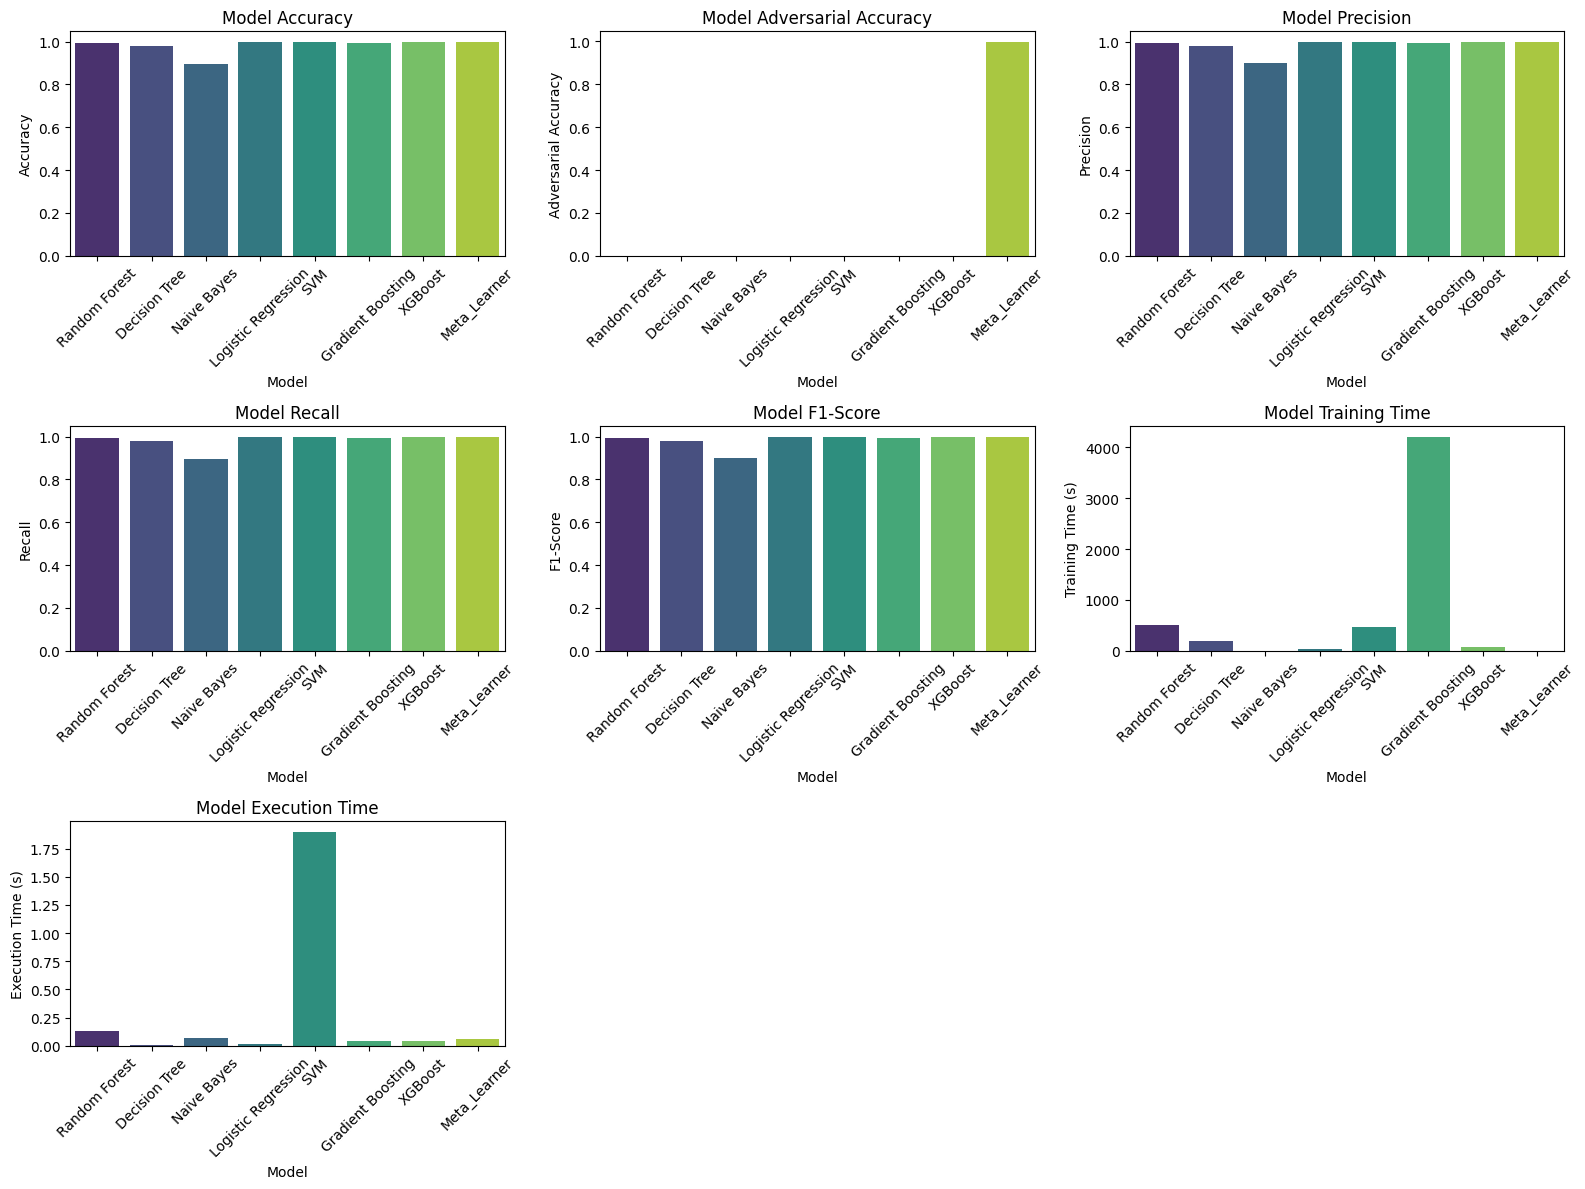

In [ ]:
# Ploting bar graphs for Accuracy, Adversarial accuracy for DistilBERT-Stacked Ensemble, Precision, Recall, F1-score, Training time, and Execution time
plt.figure(figsize=(16, 12))

plt.subplot(3, 3, 1)
sns.barplot(x='Model', y='Accuracy', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Accuracy')

plt.subplot(3, 3, 2)
sns.barplot(x='Model', y='Adversarial Accuracy', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Adversarial Accuracy')

plt.subplot(3, 3, 3)
sns.barplot(x='Model', y='Precision', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Precision')

plt.subplot(3, 3, 4)
sns.barplot(x='Model', y='Recall', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Recall')

plt.subplot(3, 3, 5)
sns.barplot(x='Model', y='F1-Score', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model F1-Score')

plt.subplot(3, 3, 6)
sns.barplot(x='Model', y='Training Time (s)', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Training Time')

plt.subplot(3, 3, 7)
sns.barplot(x='Model', y='Execution Time (s)', data=performance_df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Model Execution Time')

plt.tight_layout()
plt.show()

In [ ]:
# Function ploting confusion matrix for all models
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


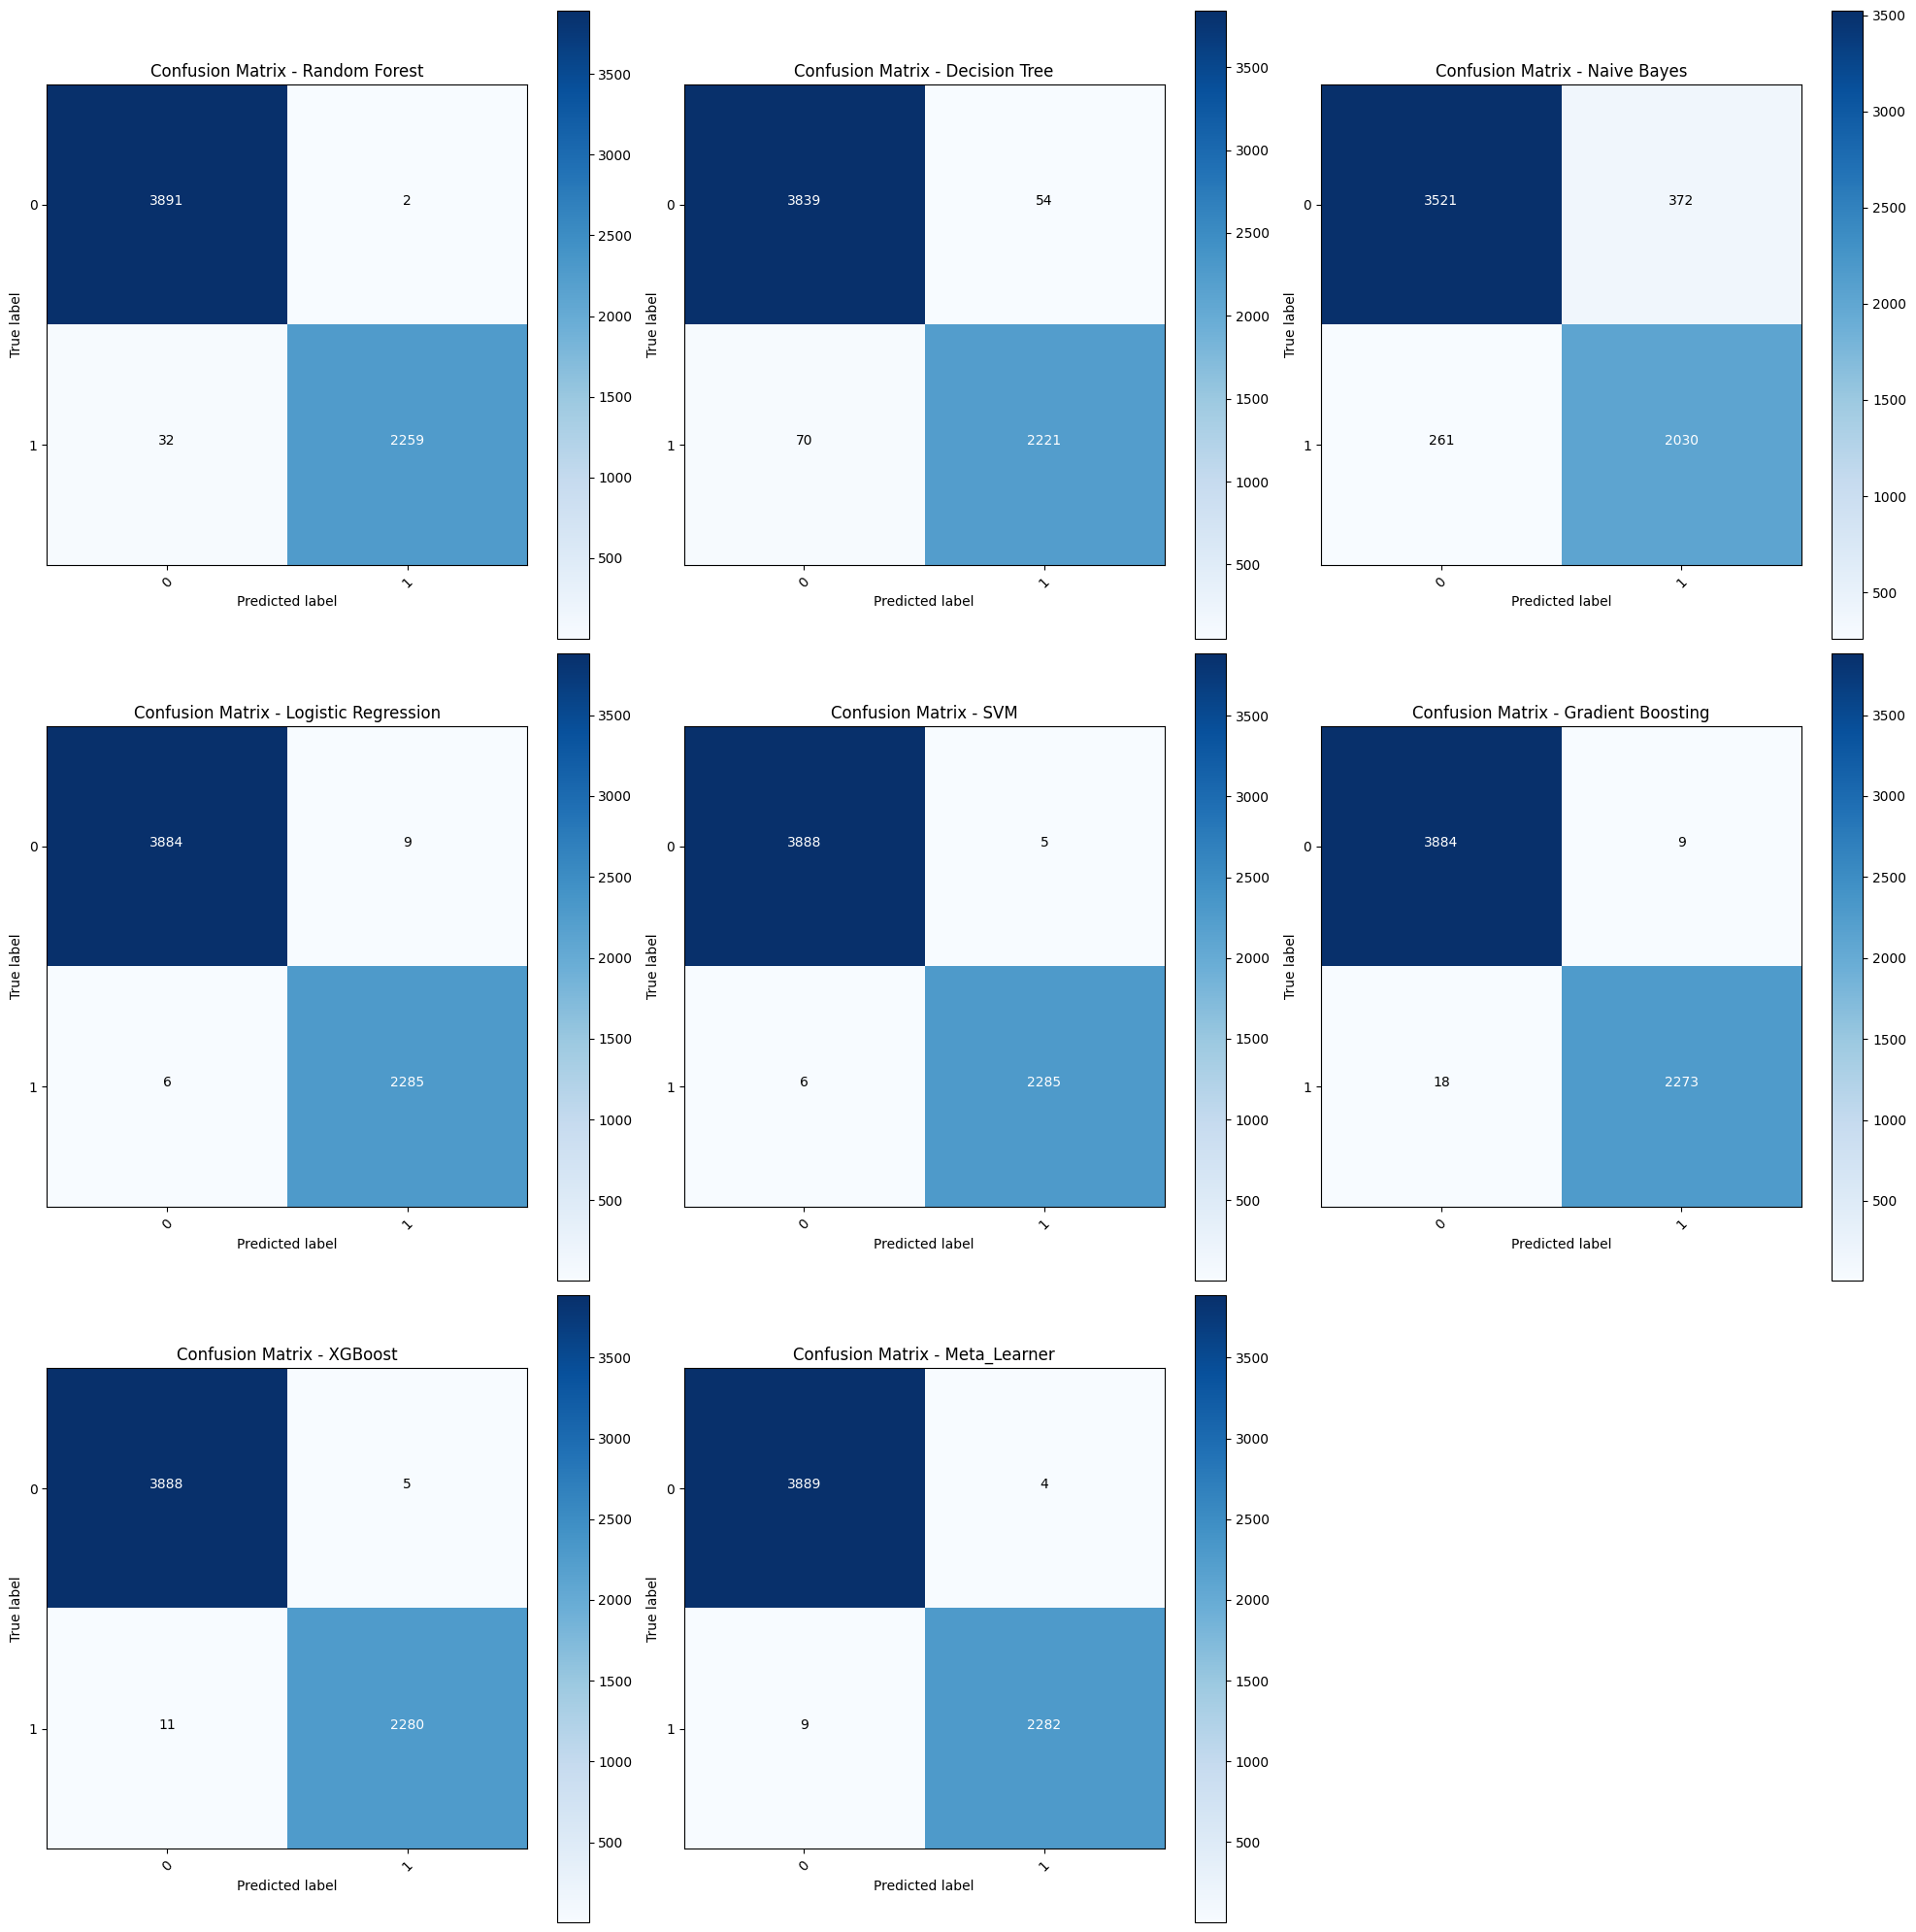

In [ ]:
# Ploting confusion matrices for all models
plt.figure(figsize=(20, 20))

model_names = list(results.keys())
num_models = len(model_names)

for i, model in enumerate(model_names):
    cm = results[model]['confusion_matrix']
    plt.subplot(int(np.ceil(num_models / 3)), 3, i + 1)  # Converting to integer
    plot_confusion_matrix(cm, classes=label_encoder.classes_, title=f'Confusion Matrix - {model}')

plt.tight_layout()
plt.show()

Hyperparameter parameter optimisation using optuna for DistilBERT-Stacked Ensemble

[I 2024-09-03 13:22:28,583] A new study created in memory with name: no-name-703698ee-131b-43b8-bf07-a44a86268785
[I 2024-09-03 13:22:29,502] Trial 0 finished with value: 0.9942591469577522 and parameters: {'hidden_dim': 132, 'dropout_rate': 0.46640221740087673, 'lr': 0.0003879830184792864, 'epochs': 47, 'epsilon': 0.3056574836297492}. Best is trial 0 with value: 0.9942591469577522.
[I 2024-09-03 13:22:30,954] Trial 1 finished with value: 0.9953911461491813 and parameters: {'hidden_dim': 124, 'dropout_rate': 0.3292957316183268, 'lr': 0.0032561422450671897, 'epochs': 81, 'epsilon': 0.26123390421678727}. Best is trial 1 with value: 0.9953911461491813.
[I 2024-09-03 13:22:32,678] Trial 2 finished with value: 0.9966848595108146 and parameters: {'hidden_dim': 218, 'dropout_rate': 0.4702427140910921, 'lr': 0.006424064762594124, 'epochs': 92, 'epsilon': 0.17182441801149997}. Best is trial 2 with value: 0.9966848595108146.
[I 2024-09-03 13:22:34,037] Trial 3 finished with value: 0.916636345259

Best hyperparameters:  {'hidden_dim': 170, 'dropout_rate': 0.42127910731395785, 'lr': 0.008318472657426962, 'epochs': 100, 'epsilon': 0.10057954282755568}
Model saved to meta_learner_model.pth


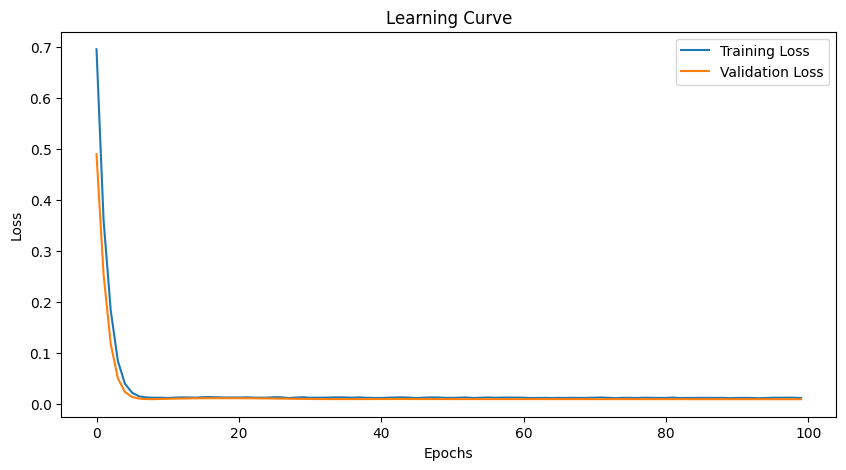

Test Accuracy: 0.9981
Adversarial Test Accuracy: 0.9977
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3893
           1       1.00      1.00      1.00      2291

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184

Confusion Matrix:
[[3887    6]
 [   6 2285]]
Training Time: 0.3967 seconds
Execution Time: 0.0136 seconds
          Model  Accuracy  Adversarial Accuracy  Precision   Recall  F1-Score  \
0  Meta-Learner   0.99806              0.997736    0.99806  0.99806   0.99806   

   Training Time (s)  Execution Time (s)  
0           0.396657             0.01356  


In [ ]:
# Ensuring train_meta_features and train_labels are available globally
train_meta_features_global = train_meta_features
train_labels_global = train_df['Label'].values  # Convert to NumPy array

# Defining the MetaLearnerNN class
class MetaLearnerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        super(MetaLearnerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 2)  # binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Function to perform FGSM attack
def fgsm_attack(data, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon * sign_data_grad
    return perturbed_data

# Function to evaluate the DistilBERT-Stacked Ensemble
def evaluate_meta_learner(meta_learner_nn, test_meta_features, test_labels, epsilon):
    start_time = time.time()
    meta_learner_nn.eval()
    test_meta_features_tensor = torch.tensor(test_meta_features, dtype=torch.float32).to(device)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

    # Evaluate on clean data
    with torch.no_grad():
        outputs = meta_learner_nn(test_meta_features_tensor)
        _, preds = torch.max(outputs, 1)
        accuracy = (preds == test_labels_tensor).sum().item() / len(test_labels_tensor)

    # Evaluate on adversarial examples data
    test_meta_features_tensor_adv = test_meta_features_tensor.clone().detach().requires_grad_(True)
    outputs_adv = meta_learner_nn(test_meta_features_tensor_adv)
    meta_learner_nn.zero_grad()
    loss_adv = nn.CrossEntropyLoss()(outputs_adv, test_labels_tensor)
    loss_adv.backward()
    data_grad = test_meta_features_tensor_adv.grad.data
    test_meta_features_tensor_adv = fgsm_attack(test_meta_features_tensor_adv, epsilon, data_grad)

    with torch.no_grad():
        outputs_adv = meta_learner_nn(test_meta_features_tensor_adv)
        _, preds_adv = torch.max(outputs_adv, 1)
        adv_accuracy = (preds_adv == test_labels_tensor).sum().item() / len(test_labels_tensor)

    # Calculating performance metrics
    preds_np = preds.cpu().numpy()
    test_labels_np = test_labels_tensor.cpu().numpy()
    report = classification_report(test_labels_np, preds_np, output_dict=True)
    conf_matrix = confusion_matrix(test_labels_np, preds_np)
    execution_time = time.time() - start_time

    return accuracy, adv_accuracy, report, conf_matrix, preds_np, execution_time

# Adversarial Examples Training Function with Loss Recording
def adversarial_train_with_loss_recording(meta_learner_nn, train_meta_features_tensor, train_labels_tensor,
                                          val_meta_features_tensor, val_labels_tensor, epsilon, epochs, lr):
    optimizer = optim.Adam(meta_learner_nn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    start_time = time.time()
    for epoch in range(epochs):
        meta_learner_nn.train()
        optimizer.zero_grad()

        # Standard training step
        outputs = meta_learner_nn(train_meta_features_tensor)
        loss = criterion(outputs, train_labels_tensor)
        loss.backward()
        optimizer.step()

        # Record training loss
        train_losses.append(loss.item())

        # Validation step
        meta_learner_nn.eval()
        with torch.no_grad():
            val_outputs = meta_learner_nn(val_meta_features_tensor)
            val_loss = criterion(val_outputs, val_labels_tensor)
            val_losses.append(val_loss.item())

        # Adversarial examples training step
        train_meta_features_tensor_adv = train_meta_features_tensor.clone().detach().requires_grad_(True)
        outputs_adv = meta_learner_nn(train_meta_features_tensor_adv)
        meta_learner_nn.zero_grad()
        loss_adv = criterion(outputs_adv, train_labels_tensor)
        loss_adv.backward()
        data_grad = train_meta_features_tensor_adv.grad.data
        train_meta_features_tensor_adv = fgsm_attack(train_meta_features_tensor_adv, epsilon, data_grad)

        outputs_adv = meta_learner_nn(train_meta_features_tensor_adv)
        loss_adv = criterion(outputs_adv, train_labels_tensor)
        loss_adv.backward()
        optimizer.step()

    train_time = time.time() - start_time
    return meta_learner_nn, train_losses, val_losses, train_time

# Objective function for Optuna hyperparameter optimisation
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    epochs = trial.suggest_int('epochs', 10, 100)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    adv_accuracies = []

    for train_index, val_index in kf.split(train_meta_features_global):
        train_features, val_features = train_meta_features_global[train_index], train_meta_features_global[val_index]
        train_labels, val_labels = train_labels_global[train_index], train_labels_global[val_index]

        train_meta_features_tensor = torch.tensor(train_features, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)
        val_meta_features_tensor = torch.tensor(val_features, dtype=torch.float32).to(device)
        val_labels_tensor = torch.tensor(val_labels, dtype=torch.long).to(device)

        meta_learner_nn = MetaLearnerNN(input_dim=train_meta_features_global.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)

        # Adversarial training
        meta_learner_nn, _, _, _ = adversarial_train_with_loss_recording(meta_learner_nn, train_meta_features_tensor, train_labels_tensor,
                                                                        val_meta_features_tensor, val_labels_tensor, epsilon, epochs, lr)

        # Evaluate on validation set
        accuracy, adv_accuracy, _, _, _, _ = evaluate_meta_learner(meta_learner_nn, val_features, val_labels, epsilon)
        accuracies.append(accuracy)
        adv_accuracies.append(adv_accuracy)

    return np.mean(adv_accuracies)

# Start the Optuna study with increased trials
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

best_hidden_dim = best_params['hidden_dim']
best_dropout_rate = best_params['dropout_rate']
best_lr = best_params['lr']
best_epochs = best_params['epochs']
best_epsilon = best_params['epsilon']

# Train the final model with the best hyperparameters
meta_learner_nn = MetaLearnerNN(input_dim=train_meta_features.shape[1], hidden_dim=best_hidden_dim, dropout_rate=best_dropout_rate).to(device)

# Adversarial training on the entire training set
train_meta_features_tensor = torch.tensor(train_meta_features, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_df['Label'].values, dtype=torch.long).to(device)
val_meta_features_tensor = torch.tensor(test_meta_features, dtype=torch.float32).to(device)
val_labels_tensor = torch.tensor(test_df['Label'].values, dtype=torch.long).to(device)

meta_learner_nn, train_losses, val_losses, train_time = adversarial_train_with_loss_recording(meta_learner_nn, train_meta_features_tensor, train_labels_tensor,
                                                                                            val_meta_features_tensor, val_labels_tensor, best_epsilon, best_epochs, best_lr)

# Save the trained model
model_path = "meta_learner_model.pth"
torch.save(meta_learner_nn.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plotting the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Loading the trained model
meta_learner_nn_loaded = MetaLearnerNN(input_dim=train_meta_features.shape[1], hidden_dim=best_hidden_dim, dropout_rate=best_dropout_rate).to(device)
meta_learner_nn_loaded.load_state_dict(torch.load(model_path))

# Evaluating the final model
accuracy, adv_accuracy, report, conf_matrix, preds_np, execution_time = evaluate_meta_learner(meta_learner_nn_loaded, test_meta_features, test_df['Label'].values, best_epsilon)

# Printing evaluation results
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Adversarial Test Accuracy: {adv_accuracy:.4f}')
print(f'Classification Report:\n{classification_report(np.array(test_df["Label"]), preds_np, target_names=[str(i) for i in np.unique(test_df["Label"])])}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Training Time: {train_time:.4f} seconds')
print(f'Execution Time: {execution_time:.4f} seconds')

# Storing results in a dictionary
results = {
    "Meta-Learner": {
        "accuracy": accuracy,
        "adversarial_accuracy": adv_accuracy,
        "report": report,
        "confusion_matrix": conf_matrix,
        "train_time": train_time,
        "execution_time": execution_time
    }
}

# Creating a DataFrame to store performance metrics
performance_metrics = {
    'Model': [],
    'Accuracy': [],
    'Adversarial Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Training Time (s)': [],
    'Execution Time (s)': []
}

# Populating the performance metrics DataFrame
for name, result in results.items():
    performance_metrics['Model'].append(name)
    performance_metrics['Accuracy'].append(result['accuracy'])
    performance_metrics['Adversarial Accuracy'].append(result.get('adversarial_accuracy', None))
    performance_metrics['Precision'].append(result['report']['weighted avg']['precision'])
    performance_metrics['Recall'].append(result['report']['weighted avg']['recall'])
    performance_metrics['F1-Score'].append(result['report']['weighted avg']['f1-score'])
    performance_metrics['Training Time (s)'].append(result['train_time'])
    performance_metrics['Execution Time (s)'].append(result['execution_time'])

performance_df = pd.DataFrame(performance_metrics)

# Displaying the summary table
print(performance_df)


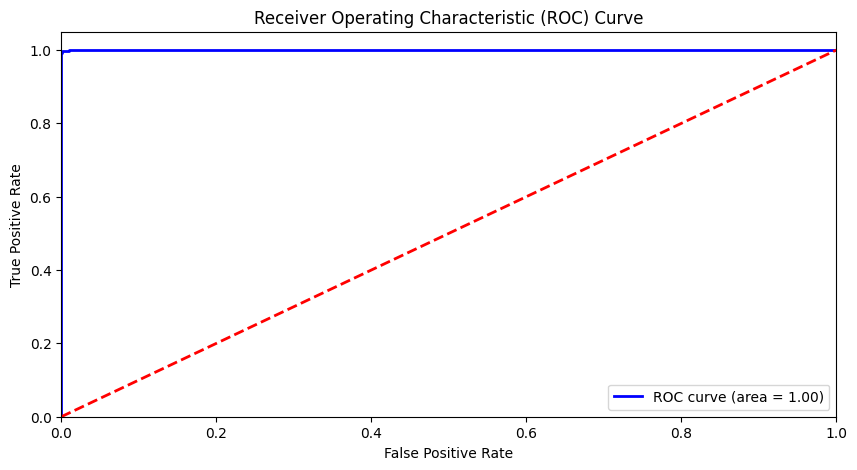

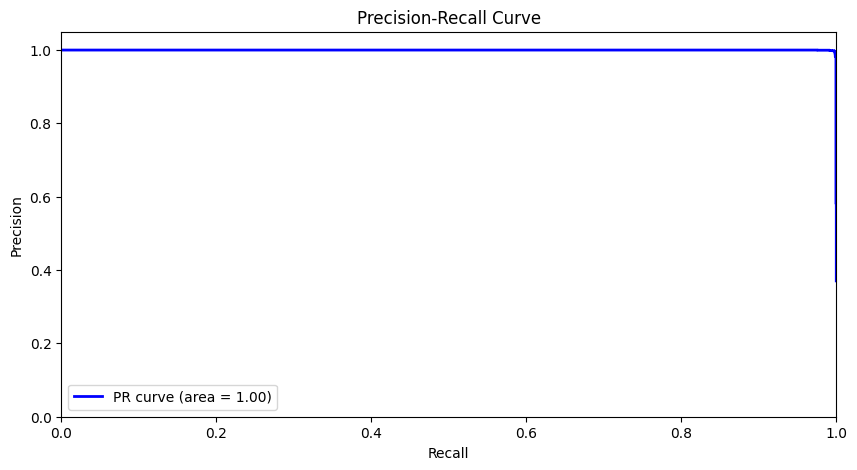

In [ ]:
# Function to plot ROC Curve for DistilBERT-Stacked Ensemble model
def plot_roc_curve(test_labels, preds_probs):
    fpr, tpr, _ = roc_curve(test_labels, preds_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall Curve DistilBERT-Stacked Ensemble
def plot_precision_recall_curve(test_labels, preds_probs):
    precision, recall, _ = precision_recall_curve(test_labels, preds_probs[:, 1])
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(10, 5))
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Get probability predictions for the test set
meta_learner_nn_loaded.eval()
test_meta_features_tensor = torch.tensor(test_meta_features, dtype=torch.float32).to(device)
with torch.no_grad():
    preds_probs = meta_learner_nn_loaded(test_meta_features_tensor).softmax(dim=1).cpu().numpy()

# Plot ROC Curve DistilBERT-Stacked Ensemble
plot_roc_curve(test_df['Label'].values, preds_probs)

# Plot Precision-Recall Curve DistilBERT-Stacked Ensemble
plot_precision_recall_curve(test_df['Label'].values, preds_probs)


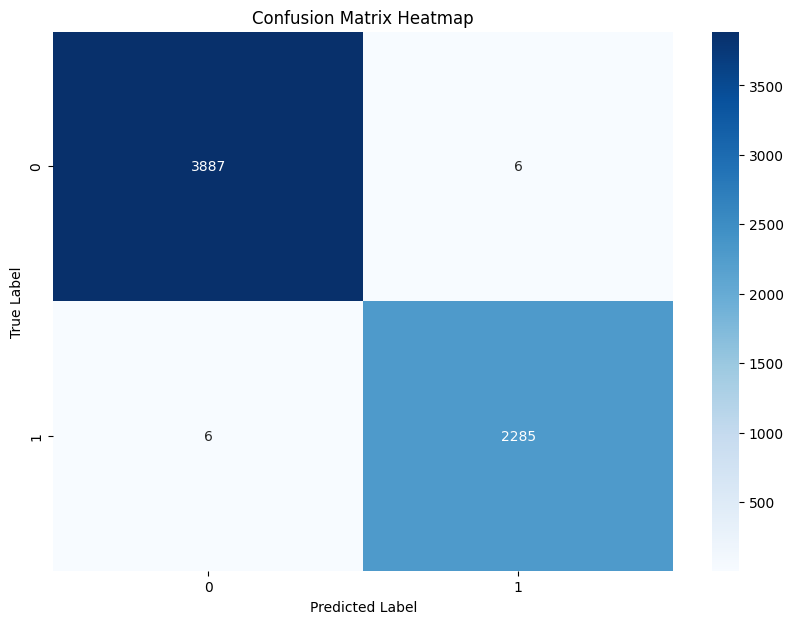

In [ ]:
# Function to plot Confusion Matrix Heatmap DistilBERT-Stacked Ensemble
def plot_confusion_matrix_heatmap(conf_matrix, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    # Plot Confusion Matrix Heatmap DistilBERT-Stacked Ensemble
plot_confusion_matrix_heatmap(conf_matrix, labels=[str(i) for i in np.unique(test_df['Label'])])


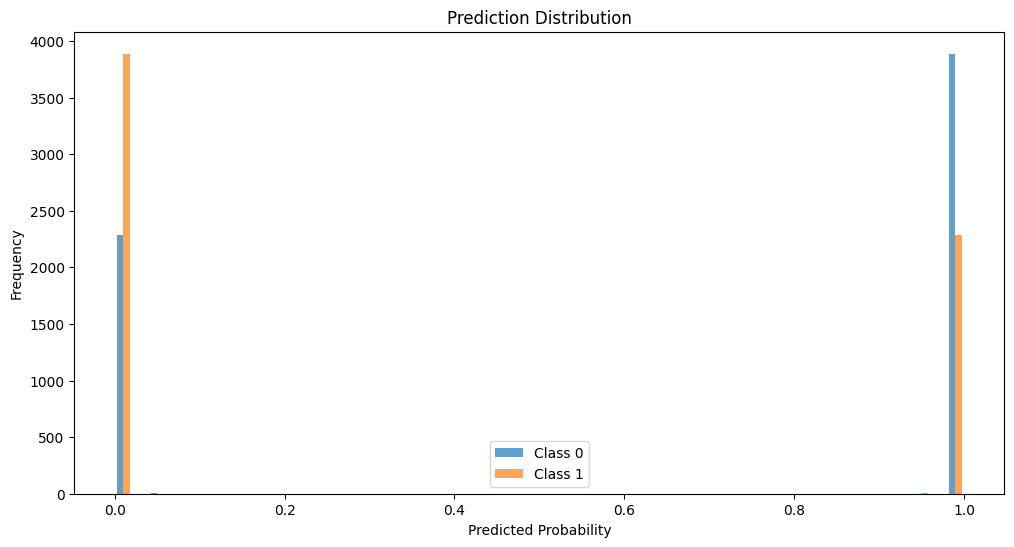

In [ ]:
# plotting predicability distribution for DistilBert-Stacked Ensemble
def plot_prediction_distribution(preds_probs):
    plt.figure(figsize=(12, 6))
    plt.hist(preds_probs, bins=50, alpha=0.7, label=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution')
    plt.legend()
    plt.show()

plot_prediction_distribution(preds_probs)


DistilBERT-Stacked Ensemble Sensitivity Analysis

In [ ]:
# Printing the shape of the meta-features to check the number of features in DistilBERT-Stacked Ensemble
print("Train meta-features shape:", train_meta_features.shape)
print("Test meta-features shape:", test_meta_features.shape)

Train meta-features shape: (24735, 6)
Test meta-features shape: (6184, 6)


In [ ]:
# Function to perturb a specific feature in the input tensor of DistilBERT-Stacked Ensemble
def perturb_feature(feature_tensor, feature_index, perturbation_type="zero"):
    perturbed_tensor = feature_tensor.clone().detach()

    if perturbation_type == "zero":
        perturbed_tensor[:, feature_index] = 0  # Zero out the feature
    elif perturbation_type == "noise":
        noise = torch.randn(perturbed_tensor[:, feature_index].shape).to(perturbed_tensor.device)
        perturbed_tensor[:, feature_index] += noise  # Adding random noise to the feature

    return perturbed_tensor

# Function to perform perturbation sensitivity analysis of DistilBERT-Stacked Ensemble
def perturbation_sensitivity_analysis(model, test_meta_features_tensor, test_labels_tensor, perturbation_type="zero"):
    model.eval()
    sensitivities = []

    original_preds = model(test_meta_features_tensor).cpu().detach().numpy()  # Get original predictions
    original_class = np.argmax(original_preds, axis=1)  # Getting predicted classes

    num_features = test_meta_features_tensor.shape[1]
    for feature_index in range(num_features):
        # Perturbing one feature at a time
        perturbed_tensor = perturb_feature(test_meta_features_tensor, feature_index, perturbation_type)
        perturbed_preds = model(perturbed_tensor).cpu().detach().numpy()  # Get perturbed predictions
        perturbed_class = np.argmax(perturbed_preds, axis=1)  # Get perturbed classes

        # Calculating sensitivity as the change in predictions
        sensitivity = np.mean(perturbed_class != original_class)
        sensitivities.append(sensitivity)
        print(f"Sensitivity for feature {feature_index}: {sensitivity:.4f}")

    average_sensitivity = np.mean(sensitivities)  # Calculate the average sensitivity
    print(f"Average sensitivity of the model: {average_sensitivity:.4f}")

    return sensitivities, average_sensitivity

# Running the sensitivity analysis of DistilBERT-Stacked Ensemble
test_meta_features_tensor = torch.tensor(test_meta_features, dtype=torch.float32).to(device)  # Convert test features to tensor
test_labels_tensor = torch.tensor(test_df['Label'].values, dtype=torch.long).to(device)  # Convert test labels to tensor

sensitivities, average_sensitivity = perturbation_sensitivity_analysis(
    meta_learner_nn_loaded, test_meta_features_tensor, test_labels_tensor, perturbation_type="zero"
)


Sensitivity for feature 0: 0.0003
Sensitivity for feature 1: 0.0003
Sensitivity for feature 2: 0.0006
Sensitivity for feature 3: 0.0005
Sensitivity for feature 4: 0.0006
Sensitivity for feature 5: 0.0008
Average sensitivity of the model: 0.0005


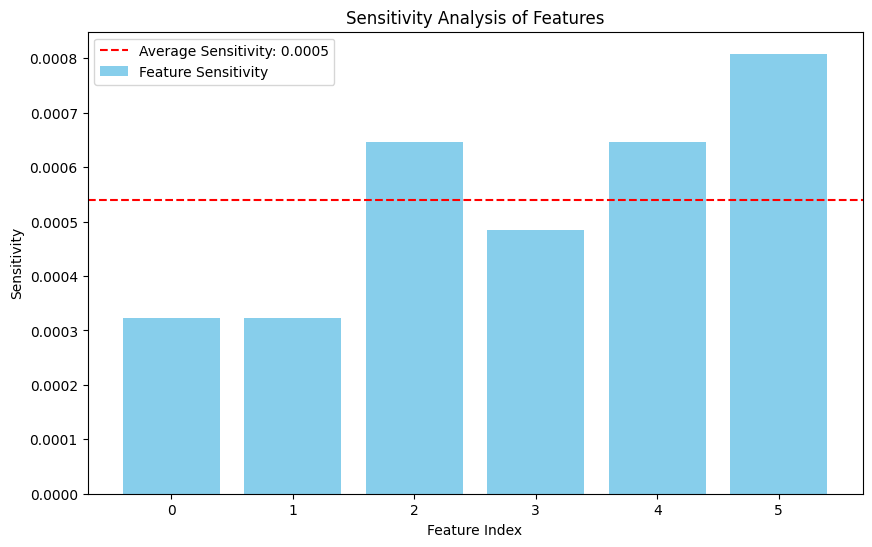

In [ ]:
# Visualisation of sensitivity analysis DistilBERT-Stacked Ensemble
plt.figure(figsize=(10, 6))
plt.bar(range(len(sensitivities)), sensitivities, color='skyblue', label='Feature Sensitivity')
plt.axhline(y=average_sensitivity, color='r', linestyle='--', label=f'Average Sensitivity: {average_sensitivity:.4f}')
plt.xlabel('Feature Index')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Analysis of Features')
plt.legend()
plt.show()

In [ ]:
# calculating the model with highest sensitivity of DistilBERT-Stacked Ensemble
model_sensitivity = {
    'Model 1': sensitivities[0] + sensitivities[1],
    'Model 2': sensitivities[2] + sensitivities[3],
    'Model 3': sensitivities[4] + sensitivities[5],
}

# Find the model with the highest sensitivity of DistilBERT-Stacked Ensemble
most_influential_model = max(model_sensitivity, key=model_sensitivity.get)
print(f"The model contributing most to predictions is {most_influential_model} with a combined sensitivity of {model_sensitivity[most_influential_model]:.4f}")


The model contributing most to predictions is Model 3 with a combined sensitivity of 0.0015


In [ ]:
# finding model with the lowest sensitivity of DistilBERT-Stacked Ensemble
model_sensitivity = {
    'Model 1': sensitivities[0] + sensitivities[1],
    'Model 2': sensitivities[2] + sensitivities[3],
    'Model 3': sensitivities[4] + sensitivities[5],
}

# Finding the model with the lowest sensitivity of DistilBERT-Stacked Ensemble
least_influential_model = min(model_sensitivity, key=model_sensitivity.get)
print(f"The model contributing least to predictions is {least_influential_model} with a combined sensitivity of {model_sensitivity[least_influential_model]:.4f}")


The model contributing least to predictions is Model 1 with a combined sensitivity of 0.0006


In [ ]:
# Calculating combined sensitivity for each model of DistilBERT-Stacked Ensemble
model_sensitivity = {
    'Model 1': sensitivities[0] + sensitivities[1],
    'Model 2': sensitivities[2] + sensitivities[3],
    'Model 3': sensitivities[4] + sensitivities[5],
}

# Normalising the sensitivity scores for comparison of DistilBERT-Stacked Ensemble
total_sensitivity = sum(model_sensitivity.values())
normalized_sensitivity = {model: (sensitivity / total_sensitivity) * 100 for model, sensitivity in model_sensitivity.items()}

# Displaying the influence of each model of DistilBERT-Stacked Ensemble
for model, sensitivity in normalized_sensitivity.items():
    print(f"{model} influence: {sensitivity:.2f}%")

# Identifying the most and least influential models of DistilBERT-Stacked Ensemble
most_influential_model = max(normalized_sensitivity, key=normalized_sensitivity.get)
least_influential_model = min(normalized_sensitivity, key=normalized_sensitivity.get)

print(f"\nThe most influential model is {most_influential_model} with {normalized_sensitivity[most_influential_model]:.2f}% influence.")
print(f"The least influential model is {least_influential_model} with {normalized_sensitivity[least_influential_model]:.2f}% influence.")


Model 1 influence: 20.00%
Model 2 influence: 35.00%
Model 3 influence: 45.00%

The most influential model is Model 3 with 45.00% influence.
The least influential model is Model 1 with 20.00% influence.
